In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
bug_image_zip_path = '/content/drive/MyDrive/Bug/images-20250703T122813Z-1-001.zip'
bug_label_zip_path = '/content/drive/MyDrive/Bug/labels-20250703T123401Z-1-001.zip'

In [11]:
import zipfile
import os

extract_path = '/content/drive/MyDrive/Bug'

# with zipfile.ZipFile(bug_image_zip_path, 'r') as zip_ref :
#   zip_ref.extractall(extract_path)
# print(f'압축 해제 완료👍 : {extract_path}')

# with zipfile.ZipFile(bug_label_zip_path, 'r') as zip_ref :
#   zip_ref.extractall(extract_path)
# print(f'압축 해제 완료👍 : {extract_path}')

In [12]:
# !apt-get update -qq

In [13]:
# !apt-get install fonts-nanum* -qq

In [14]:
import json
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import platform

In [47]:
# 한글 폰트 설정 (Colab용)
def setup_korean_font():
    """
    Google Colab에서 한글 폰트를 설정하는 함수
    """
    import subprocess
    import sys

    # Colab에서 한글 폰트 설치
    try:
        subprocess.check_call(['apt-get', 'update', '-qq'])
        subprocess.check_call(['apt-get', 'install', 'fonts-nanum*', '-qq'])

        # 폰트 캐시 업데이트
        import matplotlib.font_manager as fm
        fm._rebuild()

        # 한글 폰트 설정
        plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False

        print("한글 폰트 설정 완료!")

    except Exception as e:
        print(f"폰트 설치 중 오류: {e}")
        print("기본 폰트를 사용합니다.")
        # 기본 폰트 사용
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정 실행
setup_korean_font()

폰트 설치 중 오류: module 'matplotlib.font_manager' has no attribute '_rebuild'
기본 폰트를 사용합니다.


In [16]:
# 클래스 매핑 (JSON의 class ID -> 실제 클래스명)
class_mapping = {
    6: "나방",
    12: "노린재",
    3: "담배가루이",
    19: "무당벌레"
}

# 폴더명을 인덱스로 매핑 (모델 훈련용)
class_to_idx = {
    "나방": 0,
    "노린재": 1,
    "담배가루이": 2,
    "무당벌레": 3
}

In [33]:
def load_and_process_data(image_base_dir, json_base_dir):
    """
    클래스별 폴더에서 이미지와 JSON 파일을 로드하고 바운딩 박스 영역을 크롭하는 함수
    """
    processed_data = []

    # 클래스 폴더들을 순회 (나방, 담배가루이, 노린재, 무당벌레)
    class_folders = ['나방', '담배가루이', '노린재', '무당벌레']

    for class_folder in class_folders:
        image_class_path = os.path.join(image_base_dir, class_folder)
        json_class_path = os.path.join(json_base_dir, class_folder)

        if not os.path.exists(image_class_path):
            print(f"이미지 폴더가 존재하지 않습니다: {image_class_path}")
            continue

        if not os.path.exists(json_class_path):
            print(f"JSON 폴더가 존재하지 않습니다: {json_class_path}")
            continue

        print(f"{class_folder} 폴더 처리 중...")

        # 해당 클래스 폴더의 모든 이미지 파일 처리
        for image_file in os.listdir(image_class_path):
            if not (image_file.endswith('.jpg') or image_file.endswith('.png')):
                continue

            image_path = os.path.join(image_class_path, image_file)
            json_path = os.path.join(json_class_path, image_file + '.json')  # 라벨링 폴더에서 찾기

            # JSON 파일이 존재하는지 확인
            if not os.path.exists(json_path):
                print(f"JSON 파일을 찾을 수 없습니다: {json_path}")
                continue

            try:
                # JSON 파일 로드
                with open(json_path, 'r', encoding='utf-8') as f:
                    annotation = json.load(f)

                # 이미지 로드
                image = cv2.imread(image_path)
                if image is None:
                    print(f"이미지를 로드할 수 없습니다: {image_path}")
                    continue

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # 각 객체에 대해 처리
                for obj in annotation['annotations']['object']:
                    class_id = obj['class']

                    # 우리가 관심있는 클래스인지 확인
                    if class_id not in class_mapping:
                        continue

                    # 바운딩 박스 좌표 추출
                    bbox = obj['points'][0]
                    xtl, ytl = bbox['xtl'], bbox['ytl']
                    xbr, ybr = bbox['xbr'], bbox['ybr']

                    # 좌표 유효성 검사
                    if xtl >= xbr or ytl >= ybr or xtl < 0 or ytl < 0:
                        print(f"잘못된 바운딩 박스 좌표: {bbox}")
                        continue

                    # 바운딩 박스 영역 크롭
                    cropped_image = image[ytl:ybr, xtl:xbr]

                    # 크롭된 이미지가 유효한지 확인
                    if cropped_image.size > 0 and cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
                        processed_data.append({
                            'image': cropped_image,
                            'class_name': class_mapping[class_id],
                            'class_idx': class_to_idx[class_mapping[class_id]],
                            'bbox': (xtl, ytl, xbr, ybr),
                            'original_image': image_file,
                            'folder': class_folder
                        })

            except Exception as e:
                print(f"파일 처리 중 오류 발생 {image_file}: {e}")
                continue

    print(f"총 {len(processed_data)}개의 해충 객체를 처리했습니다.")
    return processed_data

In [34]:
def preprocess_images(data, target_size=(224, 224)):
    """
    크롭된 이미지들을 모델 입력 형태로 전처리
    """
    images = []
    labels = []

    for item in data:
        # 이미지 리사이즈
        image = cv2.resize(item['image'], target_size)
        # 정규화 (0-1 범위)
        image = image.astype(np.float32) / 255.0

        images.append(image)
        labels.append(item['class_idx'])

    return np.array(images), np.array(labels)

In [35]:
def visualize_samples(data, num_samples=8):
    """
    크롭된 이미지 샘플들을 시각화
    """
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    # 각 클래스별로 2개씩 샘플 선택
    samples_per_class = num_samples // 4
    sample_idx = 0

    for class_name in class_to_idx.keys():
        class_data = [item for item in data if item['class_name'] == class_name]

        for i in range(min(samples_per_class, len(class_data))):
            if sample_idx < num_samples:
                axes[sample_idx].imshow(class_data[i]['image'])
                axes[sample_idx].set_title(f"{class_name}")
                axes[sample_idx].axis('off')
                sample_idx += 1

    plt.tight_layout()
    plt.show()

In [42]:
def plot_training_history(history):
    """
    훈련 과정의 손실과 정확도를 시각화
    """
    plt.figure(figsize=(15, 5))

    # 서브플롯 1: 정확도
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='훈련 정확도', marker='o')
    plt.plot(history.history['val_accuracy'], label='검증 정확도', marker='s')
    plt.title('모델 정확도', fontsize=14)
    plt.xlabel('에포크', fontsize=12)
    plt.ylabel('정확도', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 2: 손실
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='훈련 손실', marker='o')
    plt.plot(history.history['val_loss'], label='검증 손실', marker='s')
    plt.title('모델 손실', fontsize=14)
    plt.xlabel('에포크', fontsize=12)
    plt.ylabel('손실', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 3: 최종 성능 요약
    plt.subplot(1, 3, 3)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    metrics = ['훈련 정확도', '검증 정확도']
    values = [final_train_acc, final_val_acc]
    colors = ['#4ECDC4', '#FF6B6B']

    bars = plt.bar(metrics, values, color=colors)

    # 막대 위에 퍼센트 표시
    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val*100:.1f}%', ha='center', va='bottom', fontsize=11)

    plt.title('최종 성능', fontsize=14)
    plt.ylabel('정확도', fontsize=12)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [43]:
def show_prediction_samples(model, X_test, y_test, class_names, num_samples=8):
    """
    예측 결과 샘플을 시각화 (정답과 예측 함께 표시)
    """
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)

    # 정답과 오답 샘플 선별
    correct_indices = np.where(y_pred == y_test)[0]
    incorrect_indices = np.where(y_pred != y_test)[0]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # 상단 4개: 정답 샘플
    for i in range(4):
        if i < len(correct_indices):
            idx = correct_indices[i]
            axes[0, i].imshow(X_test[idx])
            true_class = class_names[y_test[idx]]
            pred_class = class_names[y_pred[idx]]
            confidence = predictions[idx][y_pred[idx]] * 100
            axes[0, i].set_title(f'✓ 정답\n실제: {true_class}\n예측: {pred_class}\n신뢰도: {confidence:.1f}%',
                                color='green', fontsize=10)
            axes[0, i].axis('off')
        else:
            axes[0, i].axis('off')

    # 하단 4개: 오답 샘플
    for i in range(4):
        if i < len(incorrect_indices):
            idx = incorrect_indices[i]
            axes[1, i].imshow(X_test[idx])
            true_class = class_names[y_test[idx]]
            pred_class = class_names[y_pred[idx]]
            confidence = predictions[idx][y_pred[idx]] * 100
            axes[1, i].set_title(f'✗ 오답\n실제: {true_class}\n예측: {pred_class}\n신뢰도: {confidence:.1f}%',
                                color='red', fontsize=10)
            axes[1, i].axis('off')
        else:
            axes[1, i].axis('off')

    plt.suptitle('예측 결과 샘플', fontsize=16, y=1.02)
    plt.tight_layout()

In [36]:
def create_model(num_classes=4, input_shape=(224, 224, 3)):
    """
    Transfer Learning을 사용한 분류 모델 생성
    """
    # ResNet50 베이스 모델 (ImageNet 사전 훈련)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # 베이스 모델 가중치 고정
    base_model.trainable = False

    # 분류 헤드 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [37]:
def analyze_data_distribution(data):
    """
    데이터 분포 분석
    """
    class_counts = {}
    for item in data:
        class_name = item['class_name']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    print("\n=== 데이터 분포 ===")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}개")

    # 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('해충 클래스별 데이터 분포')
    plt.xlabel('해충 종류')
    plt.ylabel('이미지 개수')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return class_counts

In [49]:
!apt-get update -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [50]:
!apt-get install fonts-nanum* -qq

In [55]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료!")

한글 폰트 설정 완료!


In [56]:
if __name__ == "__main__":
    # 데이터 경로 설정 (프로젝트 루트의 image 폴더)
    image_base_dir = "/content/drive/MyDrive/Bug/images"
    json_base_dir = "/content/drive/MyDrive/Bug/labels"  # 또는 "json"

    print("1. 데이터 로딩 및 전처리...")
    processed_data = load_and_process_data(image_base_dir, json_base_dir)

1. 데이터 로딩 및 전처리...
나방 폴더 처리 중...
담배가루이 폴더 처리 중...
노린재 폴더 처리 중...
무당벌레 폴더 처리 중...
총 280개의 해충 객체를 처리했습니다.


/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 45812 (\N{HANGUL SYLLABLE DAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-14738522.py:21: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layou

2. 데이터 분포 분석...

=== 데이터 분포 ===
나방: 51개
담배가루이: 104개
노린재: 12개
무당벌레: 113개


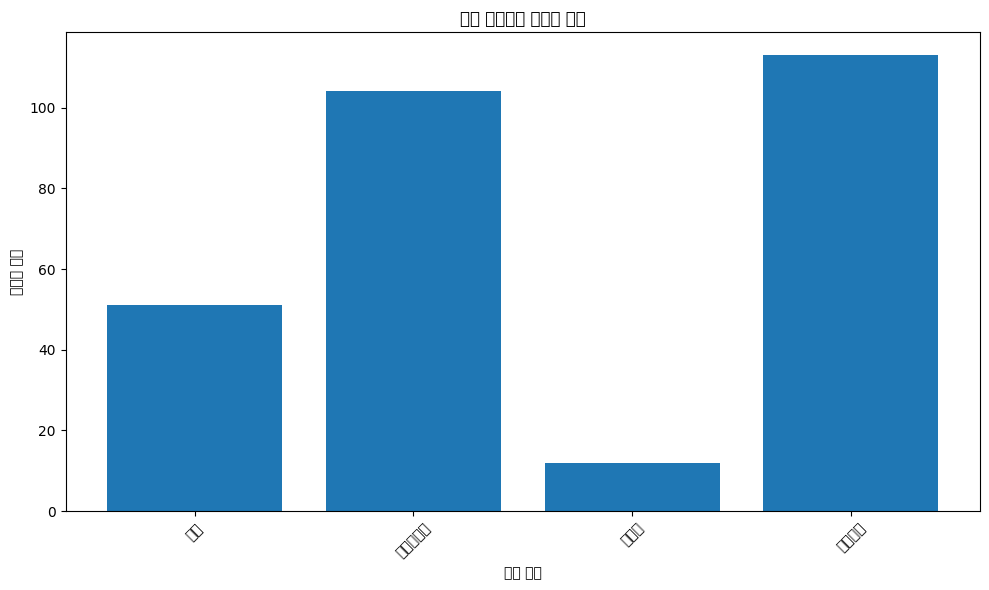

{'나방': 51, '담배가루이': 104, '노린재': 12, '무당벌레': 113}

In [57]:
    print("2. 데이터 분포 분석...")
    analyze_data_distribution(processed_data)

/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 45812 (\N{HANGUL SYLLABLE DAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.


3. 샘플 이미지 시각화...


/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 48268 (\N{HANGUL SYLLABLE BEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-35-2350929422.py:22: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


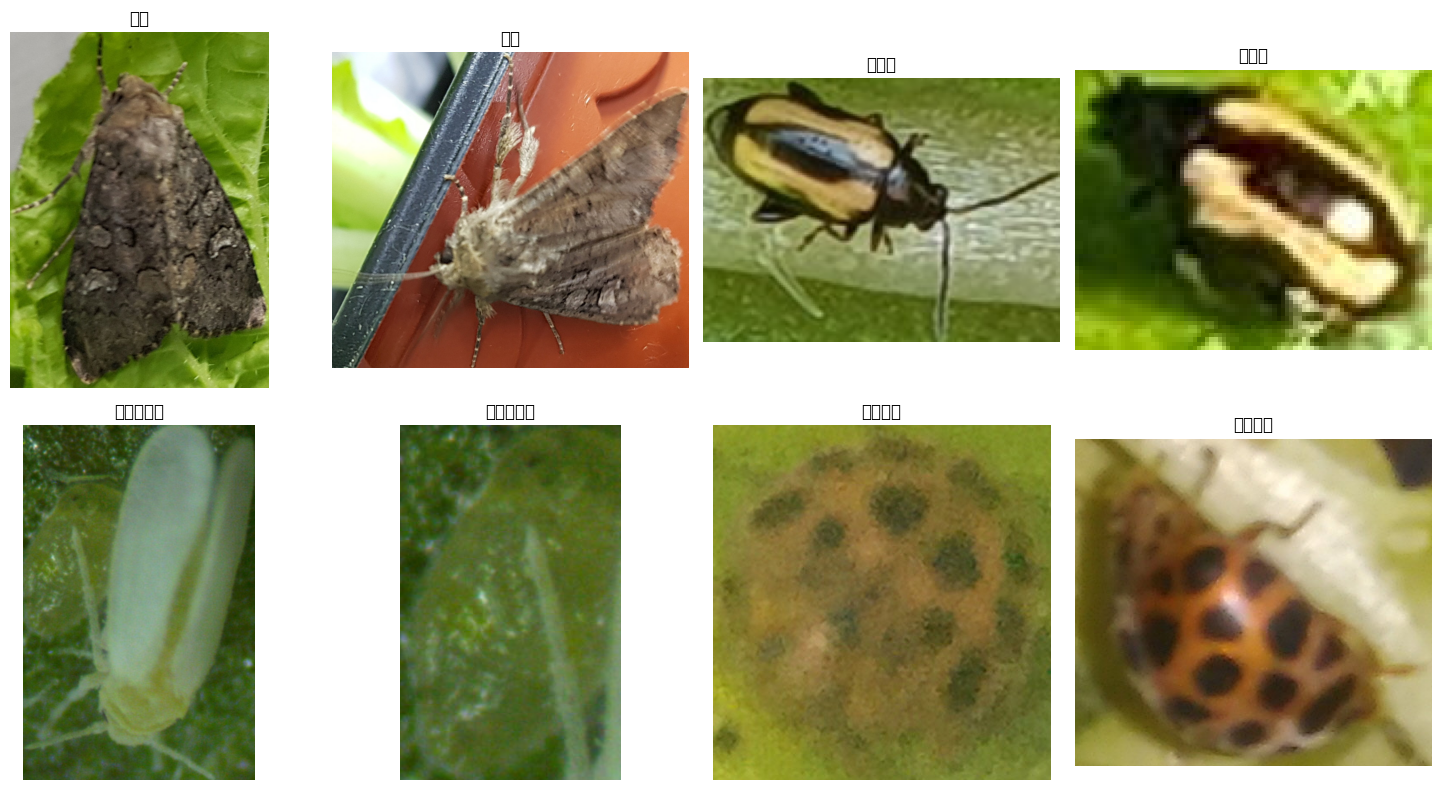

In [58]:
    print("3. 샘플 이미지 시각화...")
    visualize_samples(processed_data)

4. 모델용 데이터 전처리...
5. 데이터 분할...
6. 모델 생성...
7. 모델 컴파일...
8. 모델 훈련...
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3798 - loss: 1.4623 - val_accuracy: 0.4107 - val_loss: 1.1999
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.4386 - loss: 1.3262 - val_accuracy: 0.4107 - val_loss: 1.1574
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4171 - loss: 1.1311 - val_accuracy: 0.4643 - val_loss: 1.1390
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4407 - loss: 1.1671 - val_accuracy: 0.4107 - val_loss: 1.1416
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4565 - loss: 1.1300 - val_accuracy: 0.4464 - val_loss: 1.1328
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4300 - loss: 1.1533 - val_accuracy: 0.3929 - val_loss: 1.0740
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4484 - loss: 1.0971 - val_accuracy: 0.5357 - val_loss: 1.0781
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step -

/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-42-3805100804.py:49: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
 

9. 훈련 과정 시각화...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

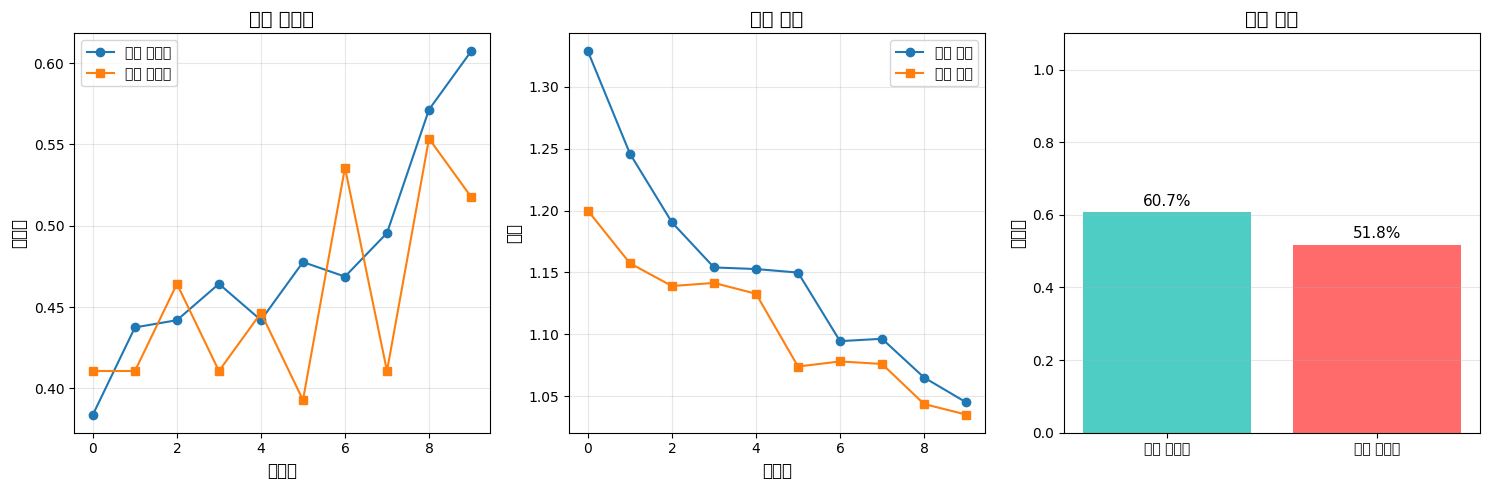

In [44]:

    print("4. 모델용 데이터 전처리...")
    X, y = preprocess_images(processed_data)

    print("5. 데이터 분할...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("6. 모델 생성...")
    model = create_model()

    print("7. 모델 컴파일...")
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("8. 모델 훈련...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1
    )

    print("9. 훈련 과정 시각화...")
    plot_training_history(history)


In [45]:
    # print("10. 모델 성능 평가...")
    # class_names = ["나방", "노린재", "담배가루이", "무당벌레"]
    # results = evaluate_model(model, X_test, y_test, class_names)

10. 모델 성능 평가...


NameError: name 'evaluate_model' is not defined

11. 예측 샘플 확인...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-43-2544882465.py:43: UserWarning: Glyph 48268 (\N{HANGUL SYLLABLE BEOL}) missing from font(s) DejaVu San

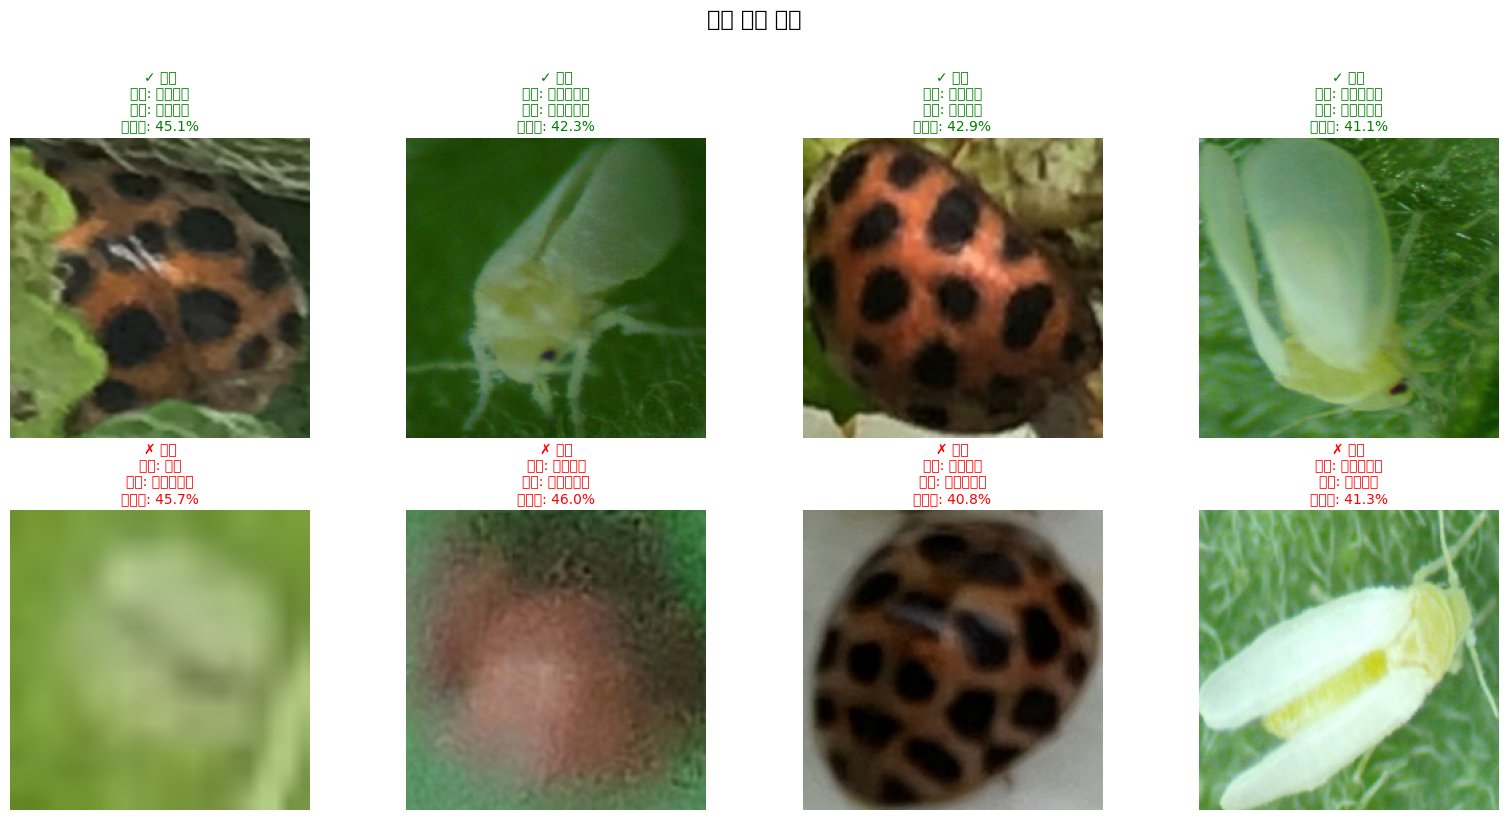

In [48]:
    print("11. 예측 샘플 확인...")
    show_prediction_samples(model, X_test, y_test, class_names)

In [ ]:
    print("12. 모델 저장...")
    model.save('insect_classifier_model.h5')
    print("모델이 저장되었습니다: insect_classifier_model.h5")